# Trend Fitness

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
import matplotlib.pyplot as plt

In [3]:

class RecommendationSystem:
    def __init__(self, df):
        self.df = df
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(df[['Primary Fitness Goal', 'Physical Activity Level', 'Nutritional Preferences', 'Fitness Environment', 'Time Commitment']].values.flatten())

    def collaborative_filtering(self, user_id, num_recommendations=5):
        user_profile = self.df.loc[self.df['Id'] == user_id]

        # Extract relevant features for collaborative filtering
        user_features = user_profile[['Primary Fitness Goal', 'Physical Activity Level']]
        all_features = self.df[['Primary Fitness Goal', 'Physical Activity Level']]

        # Concatenate user features with all features
        concatenated_features = pd.concat([user_features, all_features])

        # Encode categorical variables
        encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
        encoded_features = encoder.fit_transform(concatenated_features)

        # Split encoded features back into user and all features
        user_features_encoded = encoded_features[:1]
        all_features_encoded = encoded_features[1:]

        # Compute similarity between the target user and all users
        similarities = cosine_similarity(user_features_encoded, all_features_encoded)[0]

        # Find most similar users
        similar_users_indices = similarities.argsort()[::-1][1:]  # Exclude the target user
        similar_users = self.df.iloc[similar_users_indices]


        recommendations = {
            'Nutritional Preferences': list(set([tuple(x) if isinstance(x, list) else x for x in similar_users['Nutritional Preferences'].tolist()[:num_recommendations]])),
            'Fitness Environment': list(set([tuple(x) if isinstance(x, list) else x for x in similar_users['Fitness Environment'].tolist()[:num_recommendations]]))
        }        
        return recommendations

    def content_based_filtering(self, user_id, num_recommendations=5):
        user_profile = self.df.loc[self.df['Id'] == user_id]

        # Extract user preferences
        user_preferences = user_profile[['Primary Fitness Goal', 'Physical Activity Level', 'Nutritional Preferences', 'Fitness Environment', 'Time Commitment']]

        # Extract item features
        item_features = self.df[['Primary Fitness Goal', 'Physical Activity Level', 'Nutritional Preferences', 'Fitness Environment', 'Time Commitment']]

        # Encode user preferences and item features using the same fitted MultiLabelBinarizer
        user_features_encoded = self.mlb.transform(user_preferences.values.flatten().reshape(1, -1))
        item_features_encoded = self.mlb.transform(item_features.values.flatten().reshape(len(item_features), -1))

        # Compute similarity between items and user preferences
        similarities = cosine_similarity(user_features_encoded, item_features_encoded)

        # Sort items based on similarity and recommend top ones
        similar_items_indices = similarities.argsort()[0][::-1]
        
        recommendations = {
            'Fitness Environment': list(set([tuple(x) if isinstance(x, list) else x for x in self.df.iloc[similar_items_indices]['Fitness Environment'].tolist()[:num_recommendations]])),
            'Nutritional Preferences': list(set([tuple(x) if isinstance(x, list) else x for x in self.df.iloc[similar_items_indices]['Nutritional Preferences'].tolist()[:num_recommendations]])),
        }
        return recommendations

    def evaluate_recommendations(self, recommendations, actual_preferences):
        precision_list = []
        recall_list = []
        f1_list = []
        mae_list = []
        rmse_list = []

        for user_id, recommended in recommendations.items():
            actual = actual_preferences[actual_preferences['Id'] == user_id]

            # Convert to binary relevance (1 if present, 0 otherwise)
            actual_set = set(actual['Nutritional Preferences'].values)
            recommended_set = set(recommended['Nutritional Preferences'])

            binary_recommended = [1 if item in actual_set else 0 for item in recommended['Nutritional Preferences']]
            binary_actual = [1 if item in recommended_set else 0 for item in actual['Nutritional Preferences']]

            # Ensure binary_actual and binary_recommended are the same length
            length = max(len(binary_actual), len(binary_recommended))
            binary_actual.extend([0] * (length - len(binary_actual)))
            binary_recommended.extend([0] * (length - len(binary_recommended)))

            # Calculate metrics
            if len(binary_actual) > 0 and len(binary_recommended) > 0:
                precision = precision_score(binary_actual, binary_recommended, average='binary', zero_division=0)
                recall = recall_score(binary_actual, binary_recommended, average='binary', zero_division=0)
                f1 = f1_score(binary_actual, binary_recommended, average='binary', zero_division=0)
                mae = mean_absolute_error(binary_actual, binary_recommended)
                rmse = np.sqrt(mean_squared_error(binary_actual, binary_recommended))

                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1)
                mae_list.append(mae)
                rmse_list.append(rmse)

        return {
            'precision': np.mean(precision_list) if precision_list else 0,
            'recall': np.mean(recall_list) if recall_list else 0,
            'f1': np.mean(f1_list) if f1_list else 0,
            'mae': np.mean(mae_list) if mae_list else 0,
            'rmse': np.mean(rmse_list) if rmse_list else 0
        }


In [4]:
# Read dataset
data = pd.read_csv('fitness_dataset.csv')

df = pd.DataFrame(data)

In [5]:
# subset = df.iloc[:5, :7]
# print(subset)
df

,User ID,Primary Fitness Goal,Physical Activity Level,Medical History,Time Commitment,Nutritional Preferences,Fitness Environment,Tracking Methods,Challenges Faced
0,1,Weight Loss,Moderate,NaN,3-5 hours per week,Balanced Diet,Gym,Fitness App,Lack of Motivation
1,2,Muscle Gain,High,NaN,5-7 hours per week,High Protein Diet,Home Gym,Fitness Tracker,Time Constraints
2,3,Endurance,High,Previous Injury,5-7 hours per week,Vegetarian Diet,Outdoors,Journaling,Injury Recovery
3,4,Overall Health,Low,Hypertension,1-3 hours per week,Mediterranean Diet,Fitness Center,Self-monitoring,Lack of Knowledge
4,5,Flexibility,Low,Arthritis,1-3 hours per week,Gluten-Free Diet,Yoga Studio,Manual Logging,Pain Management
...,...,...,...,...,...,...,...,...,...
260,261,Muscle Gain,High,NaN,5-7 hours per week,High Protein Diet,Private Gym,Fitness App,Body Dysmorphia
261,262,Endurance,Moderate,Previous ACL Tear,3-5 hours per week,Balanced Diet,Running Trails,GPS Watch,Knee Pain
262,263,Overall Health,Low,Obesity,1-3 hours per week,Low Fat Diet,Senior Fitness Center,Doctor's Advice,Lack of Family Support
263,264,Flexibility,Low,Herniated Disc,1-3 hours per week,Anti-Inflammatory Diet,Physical Therapy Studio,Range of Motion Testing,Chronic Pain Management


In [6]:


# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Instantiate the recommendation system with the training data
recommendation_system = RecommendationSystem(train_df)

In [7]:
# Example usage
test_user_ids = test_df['User ID'].unique()
collaborative_recommendations = {}
content_based_recommendations = {}

for user_id in test_user_ids:
    collaborative_recommendations[user_id] = recommendation_system.collaborative_filtering(user_id)
    content_based_recommendations[user_id] = recommendation_system.content_based_filtering(user_id)

d:\project_workspace\django\trend-fitness\venv\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['1-3 hours per week', '3-5 hours per week', '5-7 hours per week', 'Alkaline Diet', 'Anti-Inflammatory Diet', 'Athletic Performance', 'Athletic Training Facility', 'Balanced Diet', 'Beach Yoga', 'Bodybuilding Gym', 'Bodyweight Fitness Park', 'Boxing Gym', 'Calcium-Rich Diet', 'Commercial Gym', 'Community Center', 'Community Fitness Center', 'Community Recreation Center', 'Core Strength', 'CrossFit Box', 'Cycling Club', 'Cycling Studio', 'Endurance', 'Fitness Center', 'Flexibility', 'Gluten-Free Diet', 'Group Fitness Classes', 'Gym', 'Heart-Healthy Diet', 'High', 'High Carb Diet', 'High Fiber Diet', 'High Protein Diet', 'Home Gym', 'Home Workout Space', 'Indoor Cycling Studio', 'Injury Prevention', 'Intermittent Fasting', 'Keto Diet', 'Ketogenic Diet', 'Low', 'Low Calorie Diet', 'Low Carb Diet', 'Low Fat Diet', 'Low Glycemic Diet', 'Low Sodium Diet', 'Macr

d:\project_workspace\django\trend-fitness\venv\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['1-3 hours per week', '3-5 hours per week', '5-7 hours per week', 'Alkaline Diet', 'Anti-Inflammatory Diet', 'Athletic Performance', 'Athletic Training Facility', 'Balanced Diet', 'Beach Yoga', 'Bodybuilding Gym', 'Bodyweight Fitness Park', 'Boxing Gym', 'Calcium-Rich Diet', 'Commercial Gym', 'Community Center', 'Community Fitness Center', 'Community Recreation Center', 'Core Strength', 'CrossFit Box', 'Cycling Club', 'Cycling Studio', 'Endurance', 'Fitness Center', 'Flexibility', 'Gluten-Free Diet', 'Group Fitness Classes', 'Gym', 'Heart-Healthy Diet', 'High', 'High Carb Diet', 'High Fiber Diet', 'High Protein Diet', 'Home Gym', 'Home Workout Space', 'Indoor Cycling Studio', 'Injury Prevention', 'Intermittent Fasting', 'Keto Diet', 'Ketogenic Diet', 'Low', 'Low Calorie Diet', 'Low Carb Diet', 'Low Fat Diet', 'Low Glycemic Diet', 'Low Sodium Diet', 'Macr

In [8]:
# Print some example recommendations
example_user_id = test_user_ids[4]
print("Collaborative Filtering Recommendations for user {}: {}".format(example_user_id, collaborative_recommendations[example_user_id]))
print("Content-Based Filtering Recommendations for user {}: {}".format(example_user_id, content_based_recommendations[example_user_id]))

Collaborative Filtering Recommendations for user 10: {'Nutritional Preferences': ['Gluten-Free Diet', 'Mediterranean Diet', 'Plant-Based Diet', 'Gluten-Free Diet', 'Anti-Inflammatory Diet'], 'Fitness Environment': ['Swimming Pool', 'Mindfulness Retreat', 'Sports Arena', 'Swimming Pool', 'Physical Therapy Studio']}
Content-Based Filtering Recommendations for user 10: {'Fitness Environment': ['Senior Center', 'Mindfulness Studio', 'Powerlifting Gym', 'Mindfulness Studio', 'Mindfulness Studio'], 'Nutritional Preferences': ['Heart-Healthy Diet', 'Balanced Diet', 'High Carb Diet', 'Balanced Diet', 'Balanced Diet']}


In [9]:
# Evaluate the recommendations
collaborative_eval = recommendation_system.evaluate_recommendations(collaborative_recommendations, test_df)
content_based_eval = recommendation_system.evaluate_recommendations(content_based_recommendations, test_df)

# Print the evaluation results
print("Collaborative Filtering Evaluation:")
print(collaborative_eval)

print("\nContent-Based Filtering Evaluation:")
print(content_based_eval)

Collaborative Filtering Evaluation:
{'precision': np.float64(0.02830188679245283), 'recall': np.float64(0.05660377358490566), 'f1': np.float64(0.03773584905660377), 'mae': np.float64(0.05660377358490567), 'rmse': np.float64(0.09691271657928169)}

Content-Based Filtering Evaluation:
{'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'mae': np.float64(0.24905660377358493), 'rmse': np.float64(0.28194887901947796)}


In [10]:
# Format the evaluation results
collaborative_metrics = {
    'precision': round(collaborative_eval['precision'], 4),
    'recall': round(collaborative_eval['recall'], 4),
    'f1': round(collaborative_eval['f1'], 4),
    'mae': round(collaborative_eval['mae'], 4),
    'rmse': round(collaborative_eval['rmse'], 4)
}

content_based_metrics = {
    'precision': round(content_based_eval['precision'], 4),
    'recall': round(content_based_eval['recall'], 4),
    'f1': round(content_based_eval['f1'], 4),
    'mae': round(content_based_eval['mae'], 4),
    'rmse': round(content_based_eval['rmse'], 4)
}

# Print the formatted results
print("collaborative_metrics = {")
for key, value in collaborative_metrics.items():
    print(f"    '{key}': {value},")
print("}")

print("\ncontent_based_metrics = {")
for key, value in content_based_metrics.items():
    print(f"    '{key}': {value},")
print("}")

collaborative_metrics = {
    'precision': 0.0283,
    'recall': 0.0566,
    'f1': 0.0377,
    'mae': 0.0566,
    'rmse': 0.0969,
}

content_based_metrics = {
    'precision': 0.0,
    'recall': 0.0,
    'f1': 0.0,
    'mae': 0.2491,
    'rmse': 0.2819,
}


In [11]:
metrics = list(collaborative_metrics.keys())
collaborative_values = list(collaborative_metrics.values())
content_based_values = list(content_based_metrics.values())

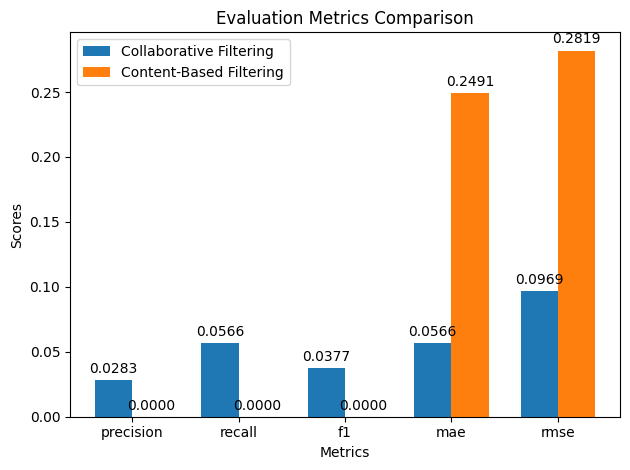

In [12]:

# Data preparation
metrics = ['precision', 'recall', 'f1', 'mae', 'rmse']
collaborative_values = [collaborative_metrics[m] for m in metrics]
content_based_values = [content_based_metrics[m] for m in metrics]

# Plotting
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, collaborative_values, width, label='Collaborative Filtering')
bars2 = ax.bar(x + width/2, content_based_values, width, label='Content-Based Filtering')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *bars*, displaying its height.
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()

plt.show()


## Dataset Resource

https://www.kaggle.com/datasets/vodkahn/healthfitness
https://www.kaggle.com/datasets/arnavsmayan/fitness-tracker-dataset
https://www.kaggle.com/datasets/nathius262/fitness-analysis